In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from scipy.constants import pi
from scipy.interpolate import RectBivariateSpline

from numpy import linalg
from numba import jit

import matplotlib as mpl
plt.rcParams['figure.figsize'] = [6, 4]
mpl.rcParams['figure.dpi'] = 100

In [17]:
stamp='1607460784'
outdir = './' + stamp

In [18]:
qs = np.load(outdir+"/qs.npy")
ns = np.load(outdir+"/ns.npy")

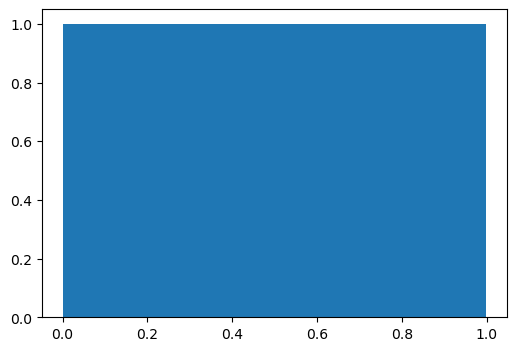

In [19]:
plt.hist(qs,bins=len(qs))
plt.show()

In [20]:
n_q = len(qs)

spec = []
for i in range(n_q):
    spec.append( np.load(outdir+"/spec_"+str(i).zfill(4)+".npy") ) 
    
spec = np.array(spec)

In [21]:
Emins = np.zeros(n_q)
Emaxs  = np.zeros(n_q)
for i in range(n_q):
    Emins[i] = np.amin(spec[i])
    Emaxs[i] = np.amax(spec[i])
    
Emin = np.amin(Emins)
Emax = np.amax(Emaxs)

In [22]:
Emax

3.996912085685168

In [23]:
@jit(nopython=True)
def fermi(E,mu,kbT):
    return 1.0 / ( np.exp( (E-mu) / kbT) + 1)

@jit(nopython=True)
def dfermi(E,mu,kbT):
    return 1.0/(2*kbT + 2*kbT*np.cosh((E - mu)/kbT))

In [24]:
@jit(nopython=True)
def ddos(mu, kbT, spec):
       
    dens = 0.0 
    
    for level in spec:
        dens += dfermi(level,mu,kbT)
        
    return dens / ( len(spec) / 2.0)

@jit(nopython=True)
def dos(mu, spec):
       
    dens = 0.0 
    
    for level in spec:
        if level < mu:
            dens += 1
        
    return dens / ( len(spec) / 2.0)

In [25]:
nmu = 600
mus = np.linspace(Emin,Emax,nmu)

x = np.zeros(nmu*n_q)
y = np.zeros(nmu*n_q)
z = np.zeros(nmu*n_q)

k = 0 
for i in range(nmu):
    for j in range(n_q):
        
        x[k] = qs[j]
        y[k] = ddos(mus[i],0.01, spec[j]) #-dos(mus[i-1], spec[j,:])
        z[k] = mus[i]
        
        k += 1
        
yy = np.reshape(y, (nmu,n_q))
fddos = RectBivariateSpline(mus, qs, yy)#,kx=5,ky=5,s=2)

In [26]:
nmu = 600
mus = np.linspace(Emin,Emax,nmu)

x = np.zeros(nmu*n_q)
y = np.zeros(nmu*n_q)
z = np.zeros(nmu*n_q)

k = 0 
for i in range(nmu):
    for j in range(n_q):
        y[k] = dos(mus[i], spec[j]) #-dos(mus[i-1], spec[j,:])
        x[k] = qs[j]
        z[k] = mus[i]
        k += 1
        
yy = np.reshape(y, (nmu,n_q))
fdos = RectBivariateSpline(mus, qs, yy)

In [27]:
nx = n_q
ny = 500
xs = np.linspace(np.amin(qs),np.amax(qs),nx)
#xs = qs
ys = np.linspace(Emin,Emax,ny)

X, Y = np.meshgrid(xs,ys,indexing='ij')
Z = np.zeros( (nx,ny))
for i in range(nx):
    for j in range(ny):
        Z[i,j] = np.abs(fddos( Y[i,j], X[i,j]))

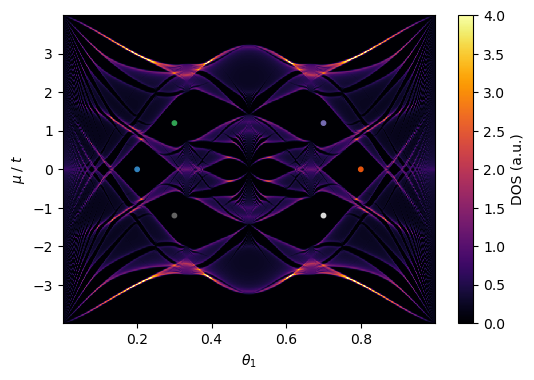

In [28]:
plt.pcolormesh(X,Y,Z, cmap='inferno',vmin=0.0, vmax=4);
ax = plt.gca()
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\mu \; / \; t$")
ax.set_ylim( (Emin,Emax))

plt.colorbar(label=r'DOS (a.u.)')

gaps = np.array( [ [0.2, 0],[0.8, 0.0], [0.3, 1.2], [0.7, 1.2], [0.3, -1.2], [0.7, -1.2] ] )

gaps_class = [0,1,2,3,4,5]

plt.scatter(gaps[:,0],gaps[:,1],c=gaps_class, cmap='tab20c',s=10)



#plt.title(r"3Q-SkX ($N_x= N_y = 70$, $k_\mathrm{B} T / t=0.1$)",fontsize=10)
plt.savefig("limacon_spectrum.png", dpi=500)
plt.show()

In [29]:
gaps_x = gaps[:,0]
gaps_y = gaps[:,1]
gaps_z = np.array( [ fdos( gaps_y[i], gaps_x[i]) for i in range(len(gaps)) ] )

In [30]:
nx = 500
ny = nx
xs = np.linspace(np.amin(qs),0.49,nx)
ys = np.linspace(Emin,Emax,ny)

X, Y = np.meshgrid(xs,ys,indexing='ij')
Z = np.zeros( (nx,ny))
for i in range(nx):
    for j in range(ny):
        Z[i,j] = fdos( Y[i,j], X[i,j]) 

/tmp/ipykernel_17624/144601945.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(np.reshape(x,(nmu,n_q)) ,np.reshape(y,(nmu,n_q)), np.reshape(z,(nmu,n_q)),


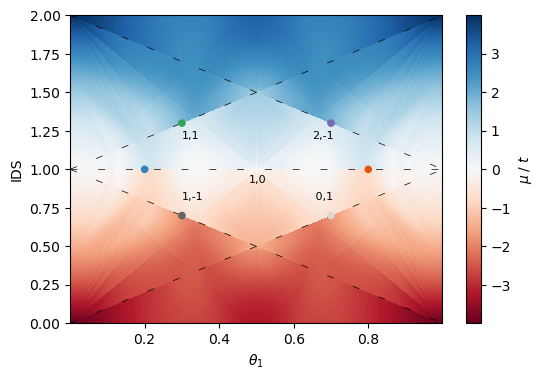

In [31]:
#plt.pcolormesh(X,Z,Y, cmap='RdBu',vmin=-0.5,vmax=7);
plt.pcolormesh(np.reshape(x,(nmu,n_q)) ,np.reshape(y,(nmu,n_q)), np.reshape(z,(nmu,n_q)),
               cmap='RdBu')#,vmin=-0.5,vmax=7)
ax = plt.gca()
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"IDS")
ax.set_ylim(0,2)
plt.colorbar(label=r"$\mu \; / \; t$")

tups = [  [1,0], [1,1], [1,-1], [2,-1], [0,1]  ]#, [1,2,-2]]

#tups = [ [ 1,0, -1 ], [0,0,1], [0,2,-1], [1,-2,1], [0,0,2], [1,0,-2], [-1,4,-2],[2,-4,2] ]

lam = 1
nsites = 1024

for tup in tups:
    n , k = tup
    spec2 = ( n + k*qs ) 
    plt.plot(qs,spec2, color='black', linewidth=.5, linestyle='--', dashes=(10, 30))

plt.scatter(gaps_x, gaps_z,c=gaps_class, cmap='tab20c', s=20, zorder=10)

ax.annotate('1,0', xy=(0.48, 0.91), rotation=0, fontsize=8)
ax.annotate('1,1', xy=(0.30, 1.2), rotation=0, fontsize=8)
ax.annotate('1,-1', xy=(0.30, 0.8), rotation=0, fontsize=8)
ax.annotate('2,-1', xy=(0.65, 1.2), rotation=0, fontsize=8)
ax.annotate(' 0,1', xy=(0.65, 0.8), rotation=0, fontsize=8)
#ax.annotate('0,2', xy=(0.60, 0.73), rotation=60)
#ax.annotate('0,3', xy=(0.49, 0.73), rotation=60)

#plt.title(r"3Q-SkX ($N_x= N_y = 70$)",fontsize=10)
plt.savefig("limacon_ktheory.png", dpi=500)
plt.show()